In [1]:
# Install required libs
!pip install -U segmentation-models-pytorch albumentations --user
# !pip uninstall -y segmentation-models-pytorch

Requirement already up-to-date: segmentation-models-pytorch in /users/zhongzha/.local/lib/python3.9/site-packages (0.3.2)
Requirement already up-to-date: albumentations in /users/zhongzha/.local/lib/python3.9/site-packages (1.3.0)


In [2]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

import matplotlib.pyplot as plt
import linzhutils as lu
from segdataset import Dataset
import os
import cv2
from torch.utils.data import DataLoader
import numpy as np

DATA_DIR = '/scratch/project_2007251/data/hel2019'
IMAGE_DIR = 'imgset'
MASK_DIR = 'maskset'
VAL_IMAGE_DIR = 'val_' + IMAGE_DIR
VAL_MASK_DIR = 'val_' + MASK_DIR

**If you run this code for the first time after downloading, please uncomment the following codes and run them. However, if it is not first time, please do not run them.**

In [3]:
if len(lu.getAllFileList(os.path.join(DATA_DIR, IMAGE_DIR))) != len(lu.getAllFileList(os.path.join(DATA_DIR, MASK_DIR))):
    print(f'File amount does not match.')
else:
    if len(lu.getAllFileList(os.path.join(DATA_DIR, VAL_IMAGE_DIR)))>0 and len(lu.getAllFileList(os.path.join(DATA_DIR, VAL_MASK_DIR)))>0:
        print('Validation data already exists.')
    else:
        lu.splitMultiData([os.path.join(DATA_DIR, IMAGE_DIR), os.path.join(DATA_DIR, MASK_DIR)],
                        [os.path.join(DATA_DIR, VAL_IMAGE_DIR), os.path.join(DATA_DIR, VAL_MASK_DIR)], 0.8)
!pwd

Validation data already exists.
/projappl/project_2007251/ForestPatches/model_zoo


In [4]:
from torch.utils.data import DataLoader
from torch.utils.data import Dataset as BaseDataset

class Dataset(BaseDataset):
    """CamVid Dataset. Read images, apply augmentation and preprocessing transformations.
    
    Args:
        images_dir (str): path to images folder
        masks_dir (str): path to segmentation masks folder
        class_values (list): values of classes to extract from segmentation mask
        augmentation (albumentations.Compose): data transfromation pipeline 
            (e.g. flip, scale, etc.)
        preprocessing (albumentations.Compose): data preprocessing 
            (e.g. noralization, shape manipulation, etc.)
    
    """
    
    CLASSES = ['other','kussi']
    
    def __init__(
            self, 
            images_dir, 
            masks_dir, 
            classes=None, 
            augmentation=None, 
            preprocessing=None,
    ):
        self.ids = os.listdir(images_dir)
        self.images_fps = [os.path.join(images_dir, image_id) for image_id in self.ids]
        self.masks_fps = [os.path.join(masks_dir, image_id) for image_id in self.ids]
        
        # convert str names to class values on masks
        self.class_values = [self.CLASSES.index(cls.lower()) for cls in classes]
        
        self.augmentation = augmentation
        self.preprocessing = preprocessing
    
    def __getitem__(self, i):
        
        # read data
        image = cv2.imread(self.images_fps[i])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.masks_fps[i], 0)
        
        # extract certain classes from mask (e.g. cars)
        masks = [(mask == v) for v in self.class_values]
        mask = np.stack(masks, axis=-1).astype('float')
        
        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        
        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
            
        return image, mask
        
    def __len__(self):
        return len(self.ids)

In [5]:
img_dir = os.path.join(DATA_DIR, IMAGE_DIR)
anno_dir = os.path.join(DATA_DIR, MASK_DIR)

val_img_dir = os.path.join(DATA_DIR, VAL_IMAGE_DIR)
val_anno_dir = os.path.join(DATA_DIR, VAL_MASK_DIR)

dataset = Dataset(img_dir, anno_dir, classes=['kussi'])


In [6]:
import albumentations as albu

def get_training_augmentation():
    train_transform = [

        albu.HorizontalFlip(p=0.5),

        albu.ShiftScaleRotate(scale_limit=0.5, rotate_limit=0, shift_limit=0.1, p=1, border_mode=0),

        albu.PadIfNeeded(min_height=512, min_width=512, always_apply=True, border_mode=0),
        albu.RandomCrop(height=512, width=512, always_apply=True),

        albu.GaussNoise(p=0.2),
        albu.Perspective(p=0.5),

        albu.OneOf(
            [
                albu.CLAHE(p=1),
                albu.RandomBrightnessContrast(p=1),
                albu.RandomGamma(p=1),
                albu.HueSaturationValue(p=1),
            ],
            p=0.9,
        ),

        albu.OneOf(
            [
                albu.Sharpen(p=1),
                # albu.Blur(blur_limit=2, p=1),
                # albu.MotionBlur(blur_limit=2, p=1),
            ],
            p=0.5,
        ),
    ]
    return albu.Compose(train_transform)


def get_validation_augmentation():
    """Add paddings to make image shape divisible by 32"""
    test_transform = [
        albu.PadIfNeeded(512, 512)
    ]
    return albu.Compose(test_transform)


def to_tensor(x, **kwargs):
    return x.transpose(2, 0, 1).astype('float32')


def get_preprocessing(preprocessing_fn):
    """Construct preprocessing transform
    
    Args:
        preprocessing_fn (callbale): data normalization function 
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose
    
    """
    
    _transform = [
        albu.Lambda(image=preprocessing_fn),
        albu.Lambda(image=to_tensor, mask=to_tensor),
    ]
    return albu.Compose(_transform)

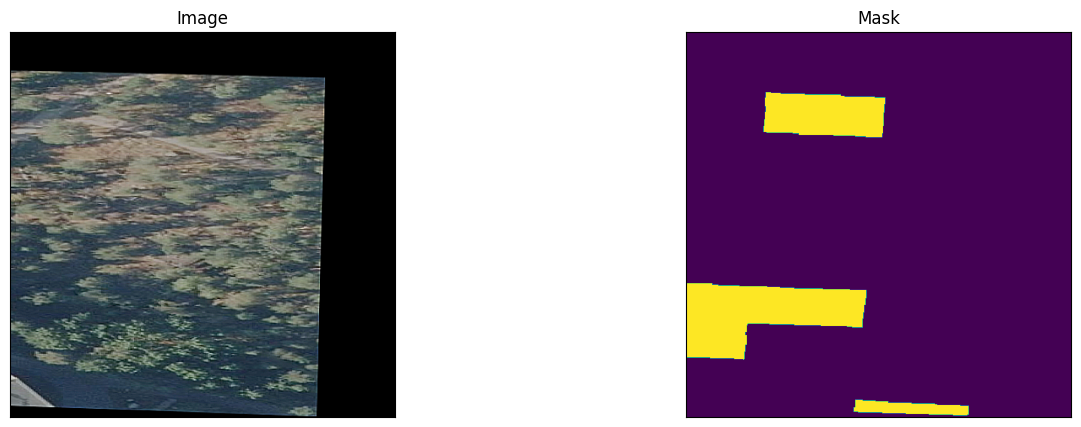

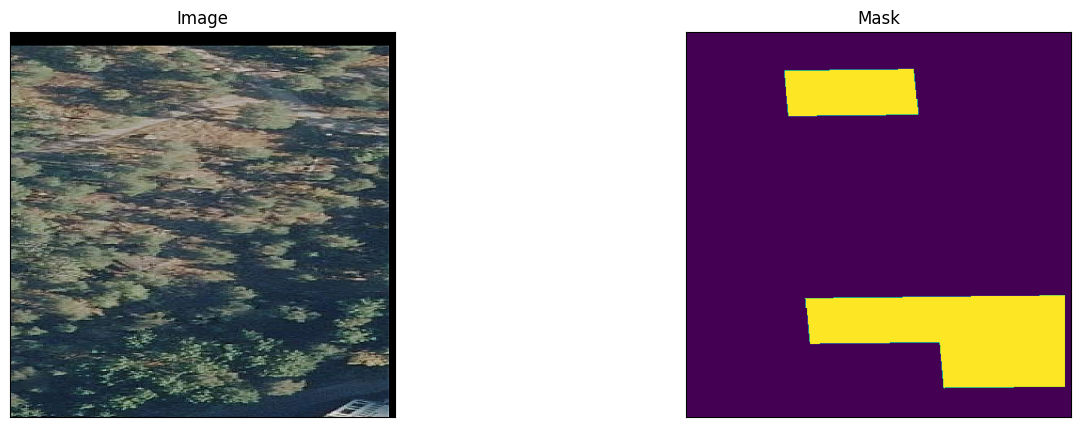

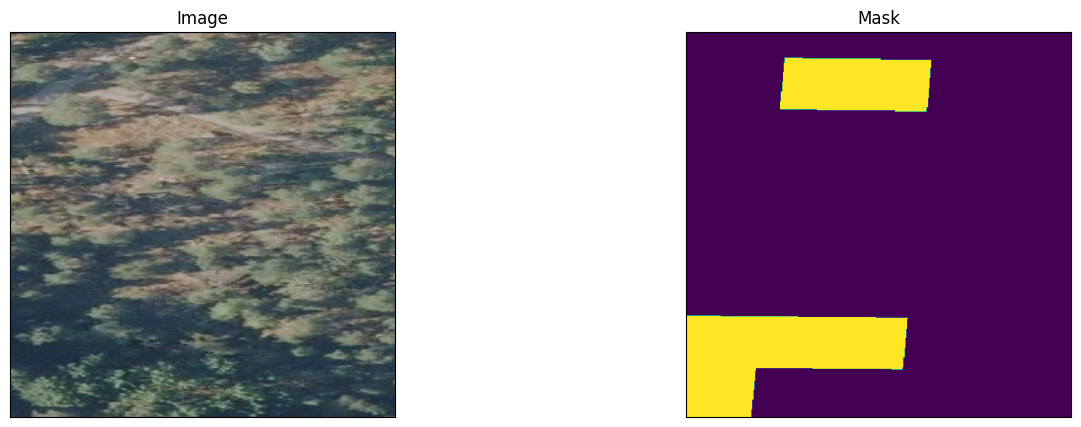

In [7]:
#### Visualize resulted augmented images and masks

def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()

augmented_dataset = Dataset(
    img_dir, 
    anno_dir, 
    augmentation=get_training_augmentation(), 
    classes=['kussi'],
)

# same image with different random transforms
for i in range(3):
    image, mask = augmented_dataset[10]
    visualize(image=image, mask=mask.squeeze(-1))

In [8]:
import torch
import numpy as np
import segmentation_models_pytorch as smp

ENCODER = 'timm-efficientnet-b8'
ENCODER_WEIGHTS = 'imagenet'
CLASSES = ['kussi']
ACTIVATION = 'sigmoid' # could be None for logits or 'softmax2d' for multiclass segmentation
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

# create segmentation model with pretrained encoder
model = smp.FPN(
    encoder_name=ENCODER, 
    encoder_weights=ENCODER_WEIGHTS, 
    classes=len(CLASSES), 
    activation=ACTIVATION,
)

preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

In [9]:
train_dataset = Dataset(
    img_dir, 
    anno_dir, 
    augmentation=get_training_augmentation(), 
    preprocessing=get_preprocessing(preprocessing_fn),
    classes=CLASSES,
)

valid_dataset = Dataset(
    val_img_dir, 
    val_anno_dir, 
    augmentation=get_validation_augmentation(), 
    preprocessing=get_preprocessing(preprocessing_fn),
    classes=CLASSES,
)

train_loader = DataLoader(train_dataset, batch_size=6, shuffle=True, num_workers=1)
valid_loader = DataLoader(valid_dataset, batch_size=4, shuffle=False, num_workers=1)

In [10]:
# Dice/F1 score - https://en.wikipedia.org/wiki/S%C3%B8rensen%E2%80%93Dice_coefficient
# IoU/Jaccard score - https://en.wikipedia.org/wiki/Jaccard_index

# loss = smp.utils.losses.DiceLoss()
from segmentation_models_pytorch import utils as smpu

loss = smp.losses.DiceLoss('binary')
loss.__name__ = 'focal_loss'
metrics = [
    smp.utils.metrics.IoU(threshold=0.5),
]

optimizer = torch.optim.Adam([ 
    dict(params=model.parameters(), lr=0.0001),
])

# create epoch runners 
# it is a simple loop of iterating over dataloader`s samples

train_epoch = smp.utils.train.TrainEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    optimizer=optimizer,
    device=DEVICE,
    verbose=True,
)

valid_epoch = smp.utils.train.ValidEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    device=DEVICE,
    verbose=True,
)

In [11]:
# train model for 40 epochs
import wandb
import random
wandb.init(project='forest_patches', entity='linzh', name=f'all_{ENCODER}-{int(random.random()*1000)}')
wandb.watch(model, log='all')

max_score = 0

train_log_list = []
valid_log_list = []

for i in range(0, 25):
    print('\nEpoch: {}'.format(i+1))
    train_logs = train_epoch.run(train_loader)
    train_log_list.append(train_logs)
    print(train_logs)
    valid_logs = valid_epoch.run(valid_loader)
    valid_log_list.append(valid_logs)
    print(valid_logs)
    
    if max_score < valid_logs['iou_score']:
        max_score = valid_logs['iou_score']
        torch.save(model, f'./{ENCODER}_{valid_logs["iou_score"]:.2f}.pth')
        print('Model saved!')
    if i == 10:
        optimizer.param_groups[0]['lr'] = 1e-5
        print('Decrease decoder learning rate to 1e-5!')
print(f'Max IOU: {max_score}')

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: linzh. Use `wandb login --relogin` to force relogin



Epoch: 1
train:  27%|██▋       | 1823/6721 [24:57<1:09:58,  1.17it/s, focal_loss - 0.8323, iou_score - 0.1792]

[ WARN:0@1505.512] global /opt/opencv-4.6.0/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('/scratch/project_2007251/data/hel2019/imgset/hel2019_10_3_7_2.png'): can't open/read file: check file path/integrity


train:  27%|██▋       | 1823/6721 [24:57<1:07:04,  1.22it/s, focal_loss - 0.8323, iou_score - 0.1792]


[ WARN:0@1506.334] global /opt/opencv-4.6.0/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('/scratch/project_2007251/data/hel2019/imgset/hel2019_34_9_1_3.png'): can't open/read file: check file path/integrity
[ WARN:0@1506.822] global /opt/opencv-4.6.0/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('/scratch/project_2007251/data/hel2019/imgset/hel2019_28_3_4_5.png'): can't open/read file: check file path/integrity


error: Caught error in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "/usr/local/lib64/python3.9/site-packages/torch/utils/data/_utils/worker.py", line 308, in _worker_loop
    data = fetcher.fetch(index)
  File "/usr/local/lib64/python3.9/site-packages/torch/utils/data/_utils/fetch.py", line 51, in fetch
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/usr/local/lib64/python3.9/site-packages/torch/utils/data/_utils/fetch.py", line 51, in <listcomp>
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/run/nvme/job_16141769/tmp/ipykernel_907852/2178475607.py", line 42, in __getitem__
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
cv2.error: OpenCV(4.6.0) /opt/opencv-4.6.0/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'



In [ ]:
print(f'Max IOU: {max_score}')

In [ ]:
# load best saved checkpoint
best_model = torch.load('./best_model.pth')

In [ ]:
# create test dataset
test_dataset = Dataset(
    val_img_dir, 
    val_anno_dir, 
    augmentation=get_validation_augmentation(), 
    preprocessing=get_preprocessing(preprocessing_fn),
    classes=CLASSES,
)

test_dataloader = DataLoader(test_dataset)

In [ ]:
# evaluate model on test set
test_epoch = smp.utils.train.ValidEpoch(
    model=best_model,
    loss=loss,
    metrics=metrics,
    device=DEVICE,
)

logs = test_epoch.run(test_dataloader)

In [ ]:
# test dataset without transformations for image visualization
test_dataset_vis = Dataset(
    val_img_dir, val_anno_dir, 
    classes=CLASSES,
)

In [ ]:
for i in range(20):
    n = np.random.choice(len(test_dataset))
    
    image_vis = test_dataset_vis[n][0].astype('uint8')
    image, gt_mask = test_dataset[n]
    
    gt_mask = gt_mask.squeeze()
    
    x_tensor = torch.from_numpy(image).to(DEVICE).unsqueeze(0)
    pr_mask = best_model.predict(x_tensor)
    pr_mask = (pr_mask.squeeze().cpu().numpy().round())
        
    visualize(
        image=image_vis, 
        ground_truth_mask=gt_mask, 
        predicted_mask=pr_mask
    )